<a href="https://colab.research.google.com/github/MHzNug/Project-Analisis-Data-Gambar/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Klasifikasi Gambar: Intel Image Classification
- **Nama:** Muhammad Husni Zahran Nugrahanto
- **Email:** mhusny1604@gmail.com
- **ID Dicoding:** mhznug

## Import Semua Packages/Library yang Digunakan

In [44]:
# Data processing libraries
import os
import shutil
import random
import zipfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Image processing libraries
import cv2
from PIL import Image
import skimage
from skimage import io
from skimage.transform import resize, rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.exposure import adjust_gamma
from skimage.util import random_noise

# Machine learning and deep learning libraries
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback

# Kaggle hub
import kagglehub

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow.keras.models import load_model
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import TFSMLayer

## Data Preparation

### Data Loading

In [2]:
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path ke file dataset:", path)

Path ke file dataset: /kaggle/input/intel-image-classification


In [3]:
all_dataset_files = os.listdir(path)
print(all_dataset_files)

['seg_train', 'seg_pred', 'seg_test']


In [4]:
train_folder = os.path.join(path, 'seg_train', 'seg_train')
test_folder = os.path.join(path, 'seg_test', 'seg_test')

combined_dataset_path = [os.path.join(train_folder, subfolder) for subfolder in os.listdir(train_folder)] + \
                        [os.path.join(test_folder, subfolder) for subfolder in os.listdir(test_folder)]

In [5]:
train_class_names = os.listdir(train_folder)
test_class_names = os.listdir(test_folder)

combined_class_names = list(set(train_class_names) | set(test_class_names))
print("Kelas gabungan dari folder training dan testing:", combined_class_names)

Kelas gabungan dari folder training dan testing: ['forest', 'sea', 'mountain', 'buildings', 'glacier', 'street']


### Data Preprocessing

#### Split Dataset

<ipython-input-6-43e04990567b>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='class_name', x='image_count', data=df_class_counts, palette='viridis',


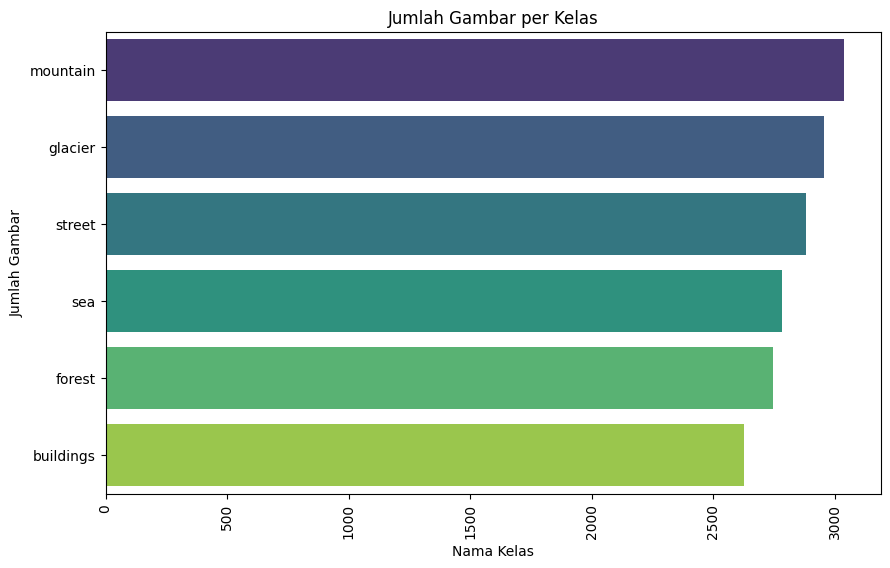

In [6]:
class_counts = []

for class_name in combined_class_names:
    class_train_path = os.path.join(train_folder, class_name)
    class_test_path = os.path.join(test_folder, class_name)

    image_paths = []
    if os.path.exists(class_train_path):
        image_paths.extend([os.path.join(class_train_path, image) for image in os.listdir(class_train_path)])
    if os.path.exists(class_test_path):
        image_paths.extend([os.path.join(class_test_path, image) for image in os.listdir(class_test_path)])

    num_images = len(image_paths)
    class_counts.append({'class_name': class_name, 'image_count': num_images})

df_class_counts = pd.DataFrame(class_counts)

plt.figure(figsize=(10, 6))
sns.barplot(y='class_name', x='image_count', data=df_class_counts, palette='viridis',
            order=df_class_counts.sort_values('image_count', ascending=False)['class_name'])
plt.title("Jumlah Gambar per Kelas")
plt.xlabel("Nama Kelas")
plt.ylabel("Jumlah Gambar")
plt.xticks(rotation=90)
plt.show()

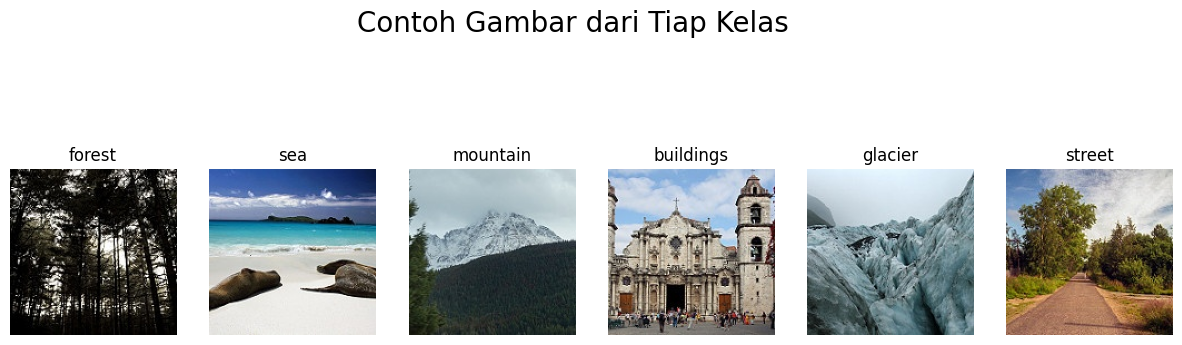

In [7]:
fig, axs = plt.subplots(1, len(combined_class_names), figsize=(15, 5))

if len(combined_class_names) == 1:
    axs = [axs]

for i, class_name in enumerate(combined_class_names):
    class_train_path = os.path.join(train_folder, class_name)
    class_test_path = os.path.join(test_folder, class_name)

    image_paths = []
    if os.path.exists(class_train_path):
        image_paths.extend([os.path.join(class_train_path, image) for image in os.listdir(class_train_path)])
    if os.path.exists(class_test_path):
        image_paths.extend([os.path.join(class_test_path, image) for image in os.listdir(class_test_path)])

    if image_paths:
        random_image_path = random.choice(image_paths)
        image = cv2.imread(random_image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        axs[i].imshow(image)
        axs[i].set_title(f"{class_name}")
        axs[i].axis('off')

plt.suptitle("Contoh Gambar dari Tiap Kelas", fontsize=20)
plt.show()

In [8]:
# Tentukan path untuk dataset baru
base_dir = 'dataset'  # Tentukan path direktori tujuan

# Buat folder untuk train, val, test
for split in ['train', 'val', 'test']:
    for class_name in combined_class_names:
        os.makedirs(os.path.join(base_dir, split, class_name), exist_ok=True)

# Loop melalui setiap kelas dan bagi datanya
for class_name in combined_class_names:
    # Ambil gambar dari masing-masing kelas
    class_train_path = os.path.join(train_folder, class_name)
    class_test_path = os.path.join(test_folder, class_name)

    # Gabungkan semua gambar
    image_paths = []
    if os.path.exists(class_train_path):
        image_paths.extend([os.path.join(class_train_path, image) for image in os.listdir(class_train_path)])
    if os.path.exists(class_test_path):
        image_paths.extend([os.path.join(class_test_path, image) for image in os.listdir(class_test_path)])

    # Bagi data menjadi train dan temp (40%)
    train_images, temp_images = train_test_split(image_paths, test_size=0.2, random_state=42)

    # Bagi data temp menjadi validation dan test (20% masing-masing)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # Salin gambar ke direktori baru
    for img in train_images:
        shutil.copy(img, os.path.join(base_dir, 'train', class_name))

    for img in val_images:
        shutil.copy(img, os.path.join(base_dir, 'val', class_name))

    for img in test_images:
        shutil.copy(img, os.path.join(base_dir, 'test', class_name))

print("Dataset telah dibagi menjadi train, validation, dan test dengan perbandingan 60-20-20.")

Dataset telah dibagi menjadi train, validation, dan test dengan perbandingan 60-20-20.


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    brightness_range=[0.5, 1],
    channel_shift_range=25,

)
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_gen = val_datagen.flow_from_directory(
    os.path.join(base_dir, 'val'),
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 13625 images belonging to 6 classes.
Found 4045 images belonging to 6 classes.
Found 4130 images belonging to 6 classes.


## Modelling

In [10]:
class StopTrainingAtAccuracy(Callback):
    def __init__(self, acc_threshold=0.95, val_acc_threshold=0.95):
        super(StopTrainingAtAccuracy, self).__init__()
        self.acc_threshold = acc_threshold
        self.val_acc_threshold = val_acc_threshold

    def on_epoch_end(self, epoch, logs=None):
        acc = logs.get("accuracy")
        val_acc = logs.get("val_accuracy")
        if acc is not None and val_acc is not None:
            if acc >= self.acc_threshold and val_acc >= self.val_acc_threshold:
                print(f"\n Target tercapai! Akurasi dan val_akurasi >= {self.acc_threshold * 100:.0f}%")
                self.model.stop_training = True

In [11]:
model = Sequential([
    InputLayer(input_shape=(150, 150, 3)),

    # Blok pertama
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Blok kedua
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    # Blok ketiga
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(6, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [12]:
callbacks = [
    StopTrainingAtAccuracy(acc_threshold=0.95, val_acc_threshold=0.95),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
]

history = model.fit(
    train_gen,
    epochs=50,
    validation_data=val_gen,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 115s 233ms/step - accuracy: 0.4687 - loss: 1.5081 - val_accuracy: 0.2656 - val_loss: 2.2504 - learning_rate: 0.0010
Epoch 2/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 88s 207ms/step - accuracy: 0.6279 - loss: 0.9991 - val_accuracy: 0.5898 - val_loss: 1.3727 - learning_rate: 0.0010
Epoch 3/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 87s 204ms/step - accuracy: 0.6880 - loss: 0.8369 - val_accuracy: 0.7758 - val_loss: 0.6062 - learning_rate: 0.0010
Epoch 4/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 88s 205ms/step - accuracy: 0.7286 - loss: 0.7326 - val_accuracy: 0.6995 - val_loss: 0.7862 - learning_rate: 0.0010
Epoch 5/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 87s 205ms/step - accuracy: 0.7482 - loss: 0.6810 - val_accuracy: 0.7358 - val_loss: 0.6944 - learning_rate: 0.0010
Epoch 6/50
426/426 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.7783 - loss: 0.6081
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
426/426 ━━━━━━━━━━━━━━━━━━━━ 87s 205ms/step - accuracy: 0.7

## Evaluasi dan Visualisasi

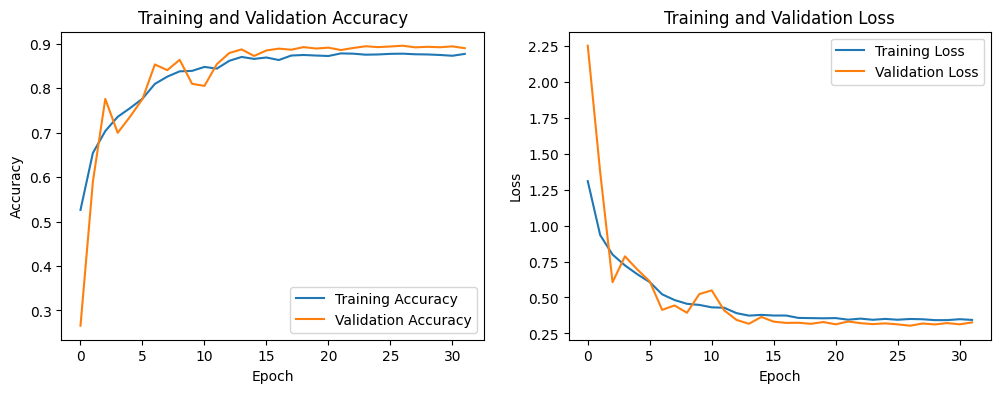

In [14]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [16]:
loss, acc = model.evaluate(test_gen)
print(f"Test Loss: {loss:.4f}, Test Accuracy: {acc:.4f}")

127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.8955 - loss: 0.3080
Test Loss: 0.3188, Test Accuracy: 0.8930


## Konversi Model

In [27]:
!pip install tensorflowjs


In [32]:
# Simpan model dalam format SavedModel
model.export('saved_model')

# Konversi ke TFLite
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

# Simpan model TFLite
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)

# Konversi ke TensorFlow.js
tfjs.converters.save_keras_model(
    model,
    'tfjs_model'
)

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  135075586526864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586528016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586527632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586527440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586529744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586530128: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586531664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586532240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586532432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586531280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135075586530320: Te

failed to lookup keras version from the file,
    this is likely a weight only file


## Inference (Optional)

In [46]:
test_image = '/content/dataset/test/forest/10050.jpg'
image = load_img(test_image, target_size=(150, 150))
image_array = img_to_array(image)
image_array /= 255.0
image_array = np.expand_dims(image_array, axis=0)

saved_model = load_model('saved_model', call_endpoint="serving_default")
predictions = saved_model.predict(image_array)
predicted_class = np.argmax(predictions)
class_labels = list(train_gen.class_indices.keys())
predicted_label = class_labels[predicted_class]

TypeError: load_model() got an unexpected keyword argument 'call_endpoint'